## T019 Molecular dynamics simulation
* https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html

### TOC
#### 1. Preparation of complex pbd
* Download PDB file
* Prepare the protein ligand complex
    * Protein preparation
    * Ligand preparation
    * Merge protein and ligand

#### 2. Create system for MD simulation
* MD simulation set up
    * Force field
    * System - protein, ligand, water, ions
#### 3. Run MD simulation
* Perform the MD simulation
* Download results

### Some tips
* For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

### Advantage of MD simulation
* MD give valuable insights into the highly dynamic process of ligand binding to their target.
* ligands may induce conformational changes in the macromolecule that can best accommodate the small molecule.
    * binding sites that are not observed in static ligand-free structures, but can be discovered with MD simulations, are sometimes called cryptic binding sites.
    * The identification of such binding sites with MD simulation can kickstart new drug discovery campaigns.
* Later in the drug discovery process, MD simulations can also be used to estimate the quality of computationally identified small molecules before performing more costly and time-intensive in vitro tests. 


In [1]:
# Load libaries
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import nglview as nv
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator


In [2]:
# create data directory if not exists
data_dir = Path("./data/EGPR_tutorial")
Path(data_dir).mkdir(parents=True, exist_ok=True)
result_dir = Path("./results/EGPR_tutorial")
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [3]:

pdbid = "3POZ" # EGFR kinase domain
ligand_name = "03P"
# check the complex structure
complex_path = str(result_dir / f"{pdbid}_{ligand_name}_complex.pdb")
complex_view = nv.show_structure_file(complex_path)
complex_view.add_representation("ball+stick", selection="not protein")
complex_view.add_representation("cartoon", selection="protein")
complex_view.add_representation("licorice", selection="water")
complex_view.add_representation("unitcell")
complex_view.camera = "orthographic"
complex_view

NGLWidget()

In [4]:
# Load the complex structure using OpenMM
complex_pdb = app.PDBFile(complex_path)
complex_topology, complex_positions = complex_pdb.topology, complex_pdb.positions


### Force field
* Common force fields like AMBER have parameters for amino acids, nucleic acids, water and ions and usually offer several options to choose from depending on your aim. 
* We use the amber14-all.xml force field file, which is shipped with OpenMM and includes parameters for proteins, DNA, RNA and lipids. For solvation we use the standard three-site water model TIP3P.

* Parameters for ligands however are not included. To generate these parameters, we can use the General AMBER ForceField (GAFF), which is implemented in the Python package OpenMM Forcefields. The following function generates a force field object holding standard AMBER parameters and additionally includes parameters for a small molecule if required.

In [5]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield

In [6]:
rcsb_ligand = Chem.MolFromMolFile(str(result_dir / f"{ligand_name}_prepared.mol"))
forcefield = generate_forcefield(rcsb_ligand)

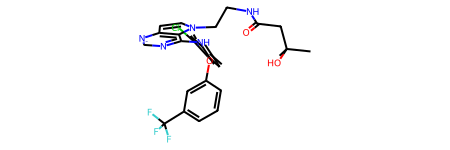

In [7]:
rcsb_ligand

### Create a system
* a simulation box which contains the complex and is filled with a solvent.
* The standard solvent is water with a specified amount of ions
* We define it with a padding, which results in a cubic box with dimensions dependent on the largest dimension of the complex.

In [8]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(forcefield, padding=1.0 * unit.nanometers, ionicStrength=0.15 * unit.molar)

/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/hyunsu/miniconda3/envs/openmm/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [9]:
with open(str(result_dir / f"{pdbid}_{ligand_name}_solvated.pdb"), "w") as f:
    app.PDBFile.writeFile(modeller.topology, modeller.positions, f)

In [10]:
print("Complex topology has", modeller.topology.getNumAtoms(), "atoms.")

Complex topology has 52862 atoms.
